# Parte 4: Clasificación con CNN

### Resultados con la arquitectura anterior: 

primero



### Cambios realizados

### Nuevos resultados: 

Resultados:
    
    TRAIN                   DEV
    loss       accuracy     val_loss    val_accuracy
    0.001835	1.0	        4.204031	0.438776
    
Por tanto: 

    E = 1 - Accuracy
    Etrain = 1 - 1.0	 = 0
    Etest = 1 - 0.438776 = 0.561224
    
    Bias = Etrain - Ehuman = 0
    Variance = Etest - Etrain = 0.561224 

El bias es muy bajo pero la varianza es muy alta (56%). Para ello habrá que o regularizar, o cambiar la arquitectura (menos neuronas => Mejor varianza, más capas => mayor abstracción), o añadir más datos (cosa que no es posible). 


### 1 - Import Libraries

In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Signal libraries
from scipy import signal


### 2 - Load data

In [2]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [3]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    mdata = mat['session']
    val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(val["task_EEG"]), np.array(val["data_EEG"]))
    return output

### Cargamos los datos

In [4]:
# Configuración
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron
from keras.utils import to_categorical


task1 = 402 # SE PUEDE CAMBIAR
task2 = 404 # SE PUEDE CAMBIAR
task_OneHotEnconding = {402: [1.,0.], 404: [0.,1.]}
user = 'W29' # SE PUEDE CAMBIAR
day = '0401'
folder_day = 'W29-01_04_2021'
total_records = 22 # CAMBIAR SI HAY MAS REGISTROS
fm = 200
electrodes_names_selected = ['F3', 'FZ', 'FC1','FCZ','C1','CZ','CP1','CPZ', 'FC5', 'FC3','C5','C3','CP5','CP3','P3',
                             'PZ','F4','FC2','FC4','FC6','C2','C4','CP2','CP4','C6','CP6','P4','HR' ,'HL', 'VU', 'VD']
number_channels = len(electrodes_names_selected)


In [5]:
# Lectura de registros
lTaskData = []

total_records_used = 0
for i_rec in range(1,total_records+1):
    i_rec_record = i_rec
    if i_rec_record <10:
        i_rec_record = "0"+str(i_rec_record)
    if i_rec % 2 != 0: # Registros impares primero: USUARIO SIN MOVIMIENTO SOLO PENSANDO
        record = "./RegistrosSinProcesar/"+folder_day+"/W29_2021"+day+"_openloop_"+str(i_rec_record)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x

        outT = (output.task == task1) | (output.task == task2)

        outData = output.data[0:np.shape(output.data)[0], outT[0,:]]
        outTask = output.task[0, outT[0,:]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)
        total_records_used+=1

print(total_records_used, total_records)

11 22


In [6]:
# Vamos a coger 2 registros para el entrenamiento, 1 para el conjunto dev set, 1 para el test set
X_train, y_train, X_dev, y_dev, X_test, y_test = [],[],[],[],[],[] 
for j in range(0,total_records_used-3): # Cogemos 8 registros para entrenamiento
    X_train.append(lTaskData[j].data)
    y_train.append(lTaskData[j].task)

for j in range(total_records_used-3,total_records_used-1): # Cogemos 2 registros para el dev set
    X_dev.append(lTaskData[j].data)
    y_dev.append(lTaskData[j].task)
for j in range(total_records_used-1,total_records_used): # Cogemos 1 registros para el test set
    X_test.append(lTaskData[j].data)
    y_test.append(lTaskData[j].task)

X_train = np.array(X_train)
#y_train = np.ravel(np.array(y_train))
y_train = np.array(y_train)
X_dev = np.array(X_dev)
#y_dev = np.ravel(np.array(y_dev))
y_dev = np.array(y_dev)
X_test = np.array(X_test)
y_test = np.array(y_test)
#y_test = np.ravel(np.array(y_test))

print ("X_train:",X_train.shape)
print ("y_train:",y_train.shape)
print ("X_dev:",X_dev.shape)
print ("y_dev:",y_dev.shape)
print ("X_test:",X_test.shape)
print ("y_test:",y_test.shape)


# VENTANEO Y ONE HOT ENCODING 
window = 300
samples_advance = 100

# Ventaneo X_train

X_train_l = []
y_train_l = []
for num_X_train in range(np.shape(X_train)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_train)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_train)[2]:
            break

        task = np.unique(y_train[num_X_train,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_train[num_X_train, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_train_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_train_l.append(taskOH)
            
        win_init += int(samples_advance)

X_train_l = np.array(X_train_l)
y_train_l = np.array(y_train_l)


# Ventaneo X_dev
X_dev_l = []
y_dev_l = []
for num_X_dev in range(np.shape(X_dev)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_dev)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_dev)[2]:
            break

        task = np.unique(y_dev[num_X_dev,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_dev[num_X_dev, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_dev_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_dev_l.append(taskOH)
            
        win_init += int(samples_advance)

X_dev_l = np.array(X_dev_l)
y_dev_l = np.array(y_dev_l)

# Ventaneo X_test
X_test_l = []
y_test_l = []
for num_X_test in range(np.shape(X_test)[0]):
    win_init = int(0)
    window_position = 0
    
    for i in range(np.shape(X_test)[2]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(X_test)[2]:
            break

        task = np.unique(y_test[num_X_test,win_init:win_end])

        if len(task)==1:
        #if task1 in task or task2 in task:
            signal_window = X_test[num_X_test, :, win_init:win_end]
            
            #data_filtered = preprocessing(signal_window, fm, number_channels)
            #X_train_l.append(data_filtered)
            X_test_l.append(signal_window)
            taskOH = task_OneHotEnconding[task[0]]
            y_test_l.append(taskOH)
            
        win_init += int(samples_advance)

X_test_l = np.array(X_test_l)
y_test_l = np.array(y_test_l)




X_train_l = X_train_l.reshape((np.shape(X_train_l)[0],np.shape(X_train_l)[1],np.shape(X_train_l)[2], 1))
X_dev_l = X_dev_l.reshape((np.shape(X_dev_l)[0],np.shape(X_dev_l)[1],np.shape(X_dev_l)[2], 1))
X_test_l = X_test_l.reshape((np.shape(X_test_l)[0],np.shape(X_test_l)[1],np.shape(X_test_l)[2], 1))


print("WINDOWING & ONE HOT ENCODER:")
print ("X_train:",X_train_l.shape)
print ("y_train:",y_train_l.shape)
print ("X_dev:",X_dev_l.shape)
print ("y_dev:",y_dev_l.shape)
print ("X_test:",X_test_l.shape)
print ("y_test:",y_test_l.shape)

X_train = X_train_l
y_train = y_train_l
X_dev = X_dev_l
y_dev = y_dev_l
X_test = X_test_l
y_test = y_test_l

X_train: (8, 31, 5600)
y_train: (8, 5600)
X_dev: (2, 31, 5600)
y_dev: (2, 5600)
X_test: (1, 31, 5600)
y_test: (1, 5600)
WINDOWING & ONE HOT ENCODER:
X_train: (392, 31, 300, 1)
y_train: (392, 2)
X_dev: (98, 31, 300, 1)
y_dev: (98, 2)
X_test: (49, 31, 300, 1)
y_test: (49, 2)


### 3. Initialize variables

In [7]:
INPUTS = X_train.shape[1]
OUTPUTS = y_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(X_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(y_train.shape[0]/1))

Some data is displayed to test correctness:

In [8]:
X_train[:2]

array([[[[ -8.09402561],
         [ -9.94211674],
         [ -7.67301702],
         ...,
         [  3.9353075 ],
         [  5.40302658],
         [  7.70658255]],

        [[ -5.0390377 ],
         [ -6.66358757],
         [ -4.47667217],
         ...,
         [  2.1584661 ],
         [  3.46315312],
         [  6.43767405]],

        [[-10.60903263],
         [-12.09577656],
         [-10.72430229],
         ...,
         [  2.3000679 ],
         [  3.46812749],
         [  6.45359421]],

        ...,

        [[  1.61085725],
         [  1.76080692],
         [ -0.56686342],
         ...,
         [ -0.50050861],
         [  3.40154266],
         [  3.74983001]],

        [[  1.47814846],
         [  0.68146783],
         [  1.03147733],
         ...,
         [  4.97134638],
         [  4.92773724],
         [  3.80344081]],

        [[  5.40894794],
         [  0.86323416],
         [ -1.62228251],
         ...,
         [ -0.30909678],
         [  0.05893415],
         [  5.403

In [9]:
X_dev[:2]

array([[[[-43.6853981 ],
         [-49.84642792],
         [-42.8303833 ],
         ...,
         [-31.06373405],
         [-28.10698128],
         [-27.32731438]],

        [[ -1.35212481],
         [ -7.82445431],
         [ -0.83776265],
         ...,
         [ -5.16151333],
         [ -0.52796578],
         [  0.42776355]],

        [[ -7.07759523],
         [-13.66497612],
         [ -6.8888979 ],
         ...,
         [-12.12047195],
         [ -9.29841518],
         [ -7.64439344]],

        ...,

        [[ -1.41719162],
         [ -8.32554913],
         [ -0.87606043],
         ...,
         [ -7.44441748],
         [ -7.2287488 ],
         [ -5.33666945]],

        [[-76.46214294],
         [-83.27526093],
         [-76.93689728],
         ...,
         [-19.95397949],
         [-19.38440323],
         [-19.66468811]],

        [[ -2.16663432],
         [-10.39913177],
         [ -2.16957879],
         ...,
         [ -8.38955307],
         [ -8.60554028],
         [ -1.974

In [10]:
y_train[:2]

array([[1., 0.],
       [1., 0.]])

In [11]:
y_train[-20]

array([0., 1.])

In [12]:
y_dev[:2]

array([[1., 0.],
       [1., 0.]])

In [13]:
X_dev[0].shape

(31, 300, 1)

In [14]:
X_dev.shape

(98, 31, 300, 1)

In [15]:
X_train.shape

(392, 31, 300, 1)

In [16]:
y_train.shape[1]

2

### 4 - Set hyperparameters

In [17]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [18]:
"""
n_epochs = 100 #2000
#learning_rate = 0.001
batch_size = 32 #250 
n_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers
rate_dropout = [0.8, 0.4, 0.2, 0.1]
weight_decay = 1e-4
"""

'\nn_epochs = 100 #2000\n#learning_rate = 0.001\nbatch_size = 32 #250 \nn_neurons_per_hlayer = [500, 250, 75, 25] # Number of units per layer, 4 hidden layers\nrate_dropout = [0.8, 0.4, 0.2, 0.1]\nweight_decay = 1e-4\n'

### 5 - Build the model: 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, DepthwiseConv2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
import keras.backend as K
#K.set_image_data_format('channels_first')

weight_decay = 1e-4

model = Sequential()
# Convolution2D(filtrosConv1, tamaño_filtro1, padding="same", input_shape=(longitud, altura,3), activation = "relu")
    # - filtrosConv1 número de filtros que aplicaremos tras la primera convolución, normalmente este tamaño va a aumentando
    # tras convoluciones para que aumente la dimensión de profundidad (qué cosas hay en mi imagen)
    # - tamaño_filtro1 tamaño espacial del kernel (de los filtros)
    # - padding = si es same es que es igual que la imagen, vamos crea una imagen del mismo tamaño con el filtro, si es 
    # valid es que no hay padding y crea una imagen más pequeña que la imagen (creo)
    # - input_shape = longitud y altura, tamaño que usará para convolucionar al entrenar
    
# CAPA PARA FILTRADO TEMPORAL
model.add(Conv2D(filters = 4, kernel_size=(1,25), padding="same", activation="relu",input_shape=(31, 300,1 ), kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
# CAPA PARA FILTRADO ESPACIAL
model.add(Conv2D(filters = 4, kernel_size=(31,1), padding="same", activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))

model.add(MaxPooling2D(pool_size=(2, 2)))
"""
model.add(Dropout(0.5))

## Siguientes capas convolucionales: 
model.add(Conv2D(20, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(40, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(80, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
"""
"""
model.add(Conv2D(160, (3,3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2,2)))
"""


"""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(96, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
#model.add(Conv2D(192, (3, 3), padding='same',activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
"""

model.add(Flatten())
model.add(Dense(y_train.shape[1], activation="softmax"))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)        
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 300, 4)        104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 300, 4)        500       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 150, 4)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9000)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 18002     
Total params: 18,606
Trainable params: 18,606
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.layers

In [21]:
for l in model.layers: print (l.name)

conv2d
conv2d_1
max_pooling2d
flatten
dense


All the parameters of a layer can bee accessed:

In [22]:
weights, biases = model.layers[0].get_weights()
weights.shape

(1, 25, 1, 4)

In [23]:
weights

array([[[[ 4.50243987e-02,  4.58692312e-02,  2.09918082e-01,
          -1.23317331e-01]],

        [[ 1.47867605e-01,  1.20574787e-01,  3.04542333e-01,
          -1.15116313e-01]],

        [[-5.17974377e-01,  3.99521887e-02,  1.12314612e-01,
          -5.95382936e-02]],

        [[-3.48448604e-01, -5.34528315e-01,  1.81690022e-01,
           2.67774552e-01]],

        [[ 1.14118448e-02,  3.02221306e-04, -6.33053422e-01,
           1.03928903e-02]],

        [[ 4.05220777e-01,  1.25764146e-01,  1.27826212e-02,
           2.02214614e-01]],

        [[ 1.77932084e-01,  2.25548550e-01, -9.38821509e-02,
          -4.16223645e-01]],

        [[-9.65219515e-04, -2.84350932e-01, -4.35686409e-01,
          -1.02792002e-01]],

        [[ 6.29089400e-02,  2.71328300e-01,  1.51945636e-01,
           3.35011810e-01]],

        [[ 5.03230393e-01,  2.42323786e-01, -2.97274739e-02,
          -1.15462780e-01]],

        [[-4.18076515e-02, -4.35901284e-01,  7.49409497e-02,
          -2.21664473e-01]],


In [24]:
biases # Bias de la primera capa: 500 bias inicializados a 0 

array([0., 0., 0., 0.], dtype=float32)

In [25]:
biases.shape

(4,)

### 6. Compile the model

### 7. Train the model with M-BGD

In [26]:
import time
start = time.time()
#history = model.fit(X_train, y_train, batch_size=32, steps_per_epoch=len(y_train)/32, epochs=100, verbose=2, validation_data=(X_dev, y_dev),callbacks=[tensorboard])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=2, validation_data=(X_dev, y_dev))
print (time.time() - start)



Epoch 1/100
13/13 - 4s - loss: 9.1976 - accuracy: 0.4872 - val_loss: 6.9167 - val_accuracy: 0.5000
Epoch 2/100
13/13 - 2s - loss: 1.8380 - accuracy: 0.6429 - val_loss: 3.1988 - val_accuracy: 0.5000
Epoch 3/100
13/13 - 2s - loss: 1.0317 - accuracy: 0.7015 - val_loss: 2.6825 - val_accuracy: 0.4592
Epoch 4/100
13/13 - 2s - loss: 0.4796 - accuracy: 0.8163 - val_loss: 2.7037 - val_accuracy: 0.5000
Epoch 5/100
13/13 - 2s - loss: 0.2355 - accuracy: 0.9056 - val_loss: 2.6330 - val_accuracy: 0.4898
Epoch 6/100
13/13 - 2s - loss: 0.1233 - accuracy: 0.9566 - val_loss: 2.7575 - val_accuracy: 0.4694
Epoch 7/100
13/13 - 2s - loss: 0.0691 - accuracy: 0.9923 - val_loss: 2.8905 - val_accuracy: 0.4490
Epoch 8/100
13/13 - 2s - loss: 0.0388 - accuracy: 1.0000 - val_loss: 2.9971 - val_accuracy: 0.4388
Epoch 9/100
13/13 - 2s - loss: 0.0313 - accuracy: 1.0000 - val_loss: 3.0090 - val_accuracy: 0.4490
Epoch 10/100
13/13 - 2s - loss: 0.0241 - accuracy: 1.0000 - val_loss: 3.0331 - val_accuracy: 0.4592
Epoch 11/

13/13 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.0971 - val_accuracy: 0.4388
Epoch 84/100
13/13 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.1040 - val_accuracy: 0.4388
Epoch 85/100
13/13 - 3s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.1107 - val_accuracy: 0.4388
Epoch 86/100
13/13 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 4.1173 - val_accuracy: 0.4388
Epoch 87/100
13/13 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1242 - val_accuracy: 0.4388
Epoch 88/100
13/13 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1307 - val_accuracy: 0.4388
Epoch 89/100
13/13 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1381 - val_accuracy: 0.4388
Epoch 90/100
13/13 - 2s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1460 - val_accuracy: 0.4694
Epoch 91/100
13/13 - 3s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1525 - val_accuracy: 0.4388
Epoch 92/100
13/13 - 3s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.1586 - val_accuracy: 0.4388
Epoch 93/100


### 8. Get the results

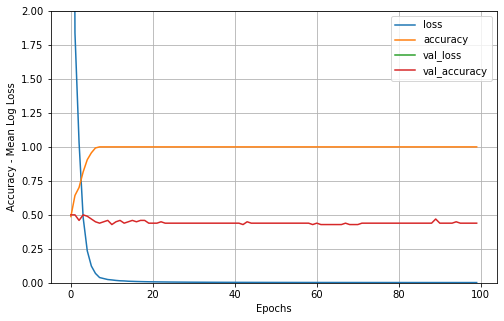

In [27]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# categorical_accuracy es el training accuracy
# val_categorical_accuracy es el validation accuracy
# loss es el training loss
# val_loss es el validation loss

# Overfitting:
# Por un lado la Accuracy de los datos de entrenamiento aumenta con las epochs,
# mientras que la Accuracy de los datos de validación disminuye o se mantiene constante a lo largo de las epochs. 
# La Loss de los datos de validación alcanza su mínimo después de pocos epochs y luego empieza a subir, 
# mientras que la Loss de los datos de entrenamiento disminuye linealmente.

In [28]:
history.params

{'verbose': 2, 'epochs': 100, 'steps': 13}

In [29]:
results[-1:]

,loss,accuracy,val_loss,val_accuracy
99,0.001835,1.0,4.204031,0.438776


In [30]:
print ("Accuracy for the training set: ", results.values[-1:][0][1])

Accuracy for the training set:  1.0


In [31]:
print ("Accuracy for the development test set: ", results.values[-1:][0][3])

Accuracy for the development test set:  0.43877550959587097


#### Let's see how the model predicts using the development test set:

In [ ]:
dev_predictions=model.predict(X_dev).round(2) 
dev_predictions[:20]

In [ ]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

In [ ]:
y_dev[:20]

In [ ]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(y_dev,1))
print (dev_correct_predictions[:30])

In [ ]:
from collections import Counter
Counter (dev_correct_predictions)

### 9. Save model

We save the model if it is better than others 

In [ ]:
# Save
model.save('./Modelos/CNN_model3.h5') # Change the name in each model

In [ ]:
# Extract
"""
new_model = keras.models.load_model('./Modelos/EGG_prac1_ANN_model3.h5')

import numpy as np

# Verify state
new_predictions = new_model.predict(X_dev)
np.testing.assert_allclose(predictions, new_predictions, rtol=1e-6, atol=1e-6)

# Note that the optimizer state is also preserved:
# you can resume training where you left off.
"""

### 10 - Final Test

#### 10.1 - Load the final test set

In [ ]:

"""
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Perceptron

total_records = 4 # CAMBIAR SI HAY MAS REGISTROS

task1 = 122 # SE PUEDE CAMBIAR
task2 = 123 # SE PUEDE CAMBIAR
task3 = 127 # SE PUEDE CAMBIAR
users = ["0091"] # SE PUEDE CAMBIAR
"""

In [ ]:
"""
def readRegisterAndReturnXy(user, total_records, task1, task2, task3 = ""):
    lTaskData = []
    for i_rec in range(1,total_records+1):
            record = "userS"+user+"f"+str(i_rec)+".mat"
            output = read_outputs(record) # output.task será y, output.data será x

            if task3 != "":
                outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
            else: 
                outT = (output.task == task1) | (output.task == task2)
            outData = output.data[outT[:,0],0:np.shape(output.data)[1]]

            outTask = output.task[outT[:,0]]
            outTD = OutTaskData(outTask, outData)
            lTaskData.append(outTD)

    X_test, y_test = [],[]
    for j in range(0,total_records):
        X_test.extend(lTaskData[j].data)
        y_test.extend(lTaskData[j].task)

    X_test = np.array(X_test)
    y_test = np.ravel(np.array(y_test))

    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)

    # ONE HOT ENCODER
    encoder = make_pipeline(StandardScaler(), OneHotEncoder(categories="auto", sparse=False)) # Function that one-hot encodes integers))
    y_test = encoder.fit_transform (y_test.reshape(-1,1)) # y_one_hot

    print("ONE HOT ENCODER:")
    print ("X_test:",X_test.shape)
    print ("y_test:",y_test.shape)
    
    return X_test, y_test
"""

In [ ]:
"""
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)


"""

#### 10.2 - Evaluate the model

In [ ]:
from collections import Counter
def predictWithModel(model, X_test, y_test, task1, task2, task3=""):
    model.evaluate(X_test, y_test)
    test_predictions = model.predict(X_test)
    test_rounded_predictions=np.round(test_predictions)
    indices = np.argmax(test_predictions,1)
    for row, index in zip(test_rounded_predictions, indices): row[index]=1
    print(test_rounded_predictions[:20])
    
    # ACCURACY:
    test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(y_test,1))
    print()
    print(test_correct_predictions)
    print(type(test_correct_predictions))
    final_test_prediction_results=Counter(test_correct_predictions)
    
    success = np.mean(test_rounded_predictions == y_test)*100
    
    return final_test_prediction_results, success

In [ ]:
users = ["0091"]
for u in users:   
    print("USER:", u)
    #X_test, y_test = readRegisterAndReturnXy(u, total_records, 122, 123, 127)
    accuracy, success = predictWithModel(model, X_test, y_test, 402,404)
    print(u, accuracy, success)
    print()

In [ ]:
#model.evaluate(x_final_test, t_final_test) # Un 77 es un accuracy bajo 

The outputs computed by the neural network for the final testing dataset.

In [ ]:
"""
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]
"""

The target outputs.

In [ ]:
# t_final_test[:20]

The first 30 predictions. True means that the neural network correctly classifies the input vector.

In [ ]:
# test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
# test_correct_predictions[:30]

#### The final test accuracy.

In [ ]:
"""from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results"""

In [ ]:
#final_test_prediction_results[True]/sum(final_test_prediction_results.values())